In [19]:
import os, sys
sys.path.insert(1, '../dataset')
import data_preparation
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
import torch
# from abte import ABTEModel
from utils import tag_to_word_df

In [2]:
#prepare data
if not os.path.exists('../dataset/prepared'):
    os.makedirs('../dataset/prepared')
data_preparation.to_csv('../dataset/atepc/restaurants_test.csv', '../dataset/prepared/restaurants_test.csv',)
data_preparation.to_csv('../dataset/atepc/restaurants_train.csv', '../dataset/prepared/restaurants_train.csv',)

# Text normalization

In [51]:
# spelling check
from textblob import TextBlob
import contractions

def normalize(data):
    d = data
    def correct(token_list):
        l = token_list.replace("'", "").strip("][").split(', ')
        # abbreviations
        l = [contractions.fix(ll) for ll in l ]
        s = ' '.join(l)
        s = str(TextBlob(s).correct().words)
        return s 
    d['Tokens'] = d['Tokens'].apply(lambda x: correct(x))
    return d
data_test = normalize(data_test)
data = normalize(data)

In [52]:
#normalized data
if not os.path.exists('../dataset/normalized'):
    os.makedirs('../dataset/normalized')
data_test.to_csv('../dataset/normalized/restaurants_test.csv', index=False)
data.to_csv('../dataset/normalized/restaurants_train.csv', index=False)

# ABTE

In [17]:
from transformers import BertModel
from transformers import get_scheduler

import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

import time
import numpy as np
import os
from tqdm import tqdm

class ABTEDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        tokens, tags, pols = self.df.iloc[idx, :3].values

        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').split(', ')
        pols = pols.strip('][').split(', ')

        bert_tokens = []
        bert_tags = []
        bert_pols = []
        for i in range(len(tokens)):
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            bert_tags += [int(tags[i])]*len(t)
            bert_pols += [int(pols[i])]*len(t)
        
        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        tags_tensor = torch.tensor(bert_tags)
        pols_tensor = torch.tensor(bert_pols)
        return bert_tokens, ids_tensor, tags_tensor, pols_tensor

    def __len__(self):
        return len(self.df)

class ABTEBert(torch.nn.Module):
    def __init__(self, pretrain_model, adapter=True):
        super(ABTEBert, self).__init__()
        self.adapter = adapter
        if adapter:
            from transformers.adapters import BertAdapterModel
            self.bert = BertAdapterModel.from_pretrained(pretrain_model)
        else: self.bert = BertModel.from_pretrained(pretrain_model)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, tags_tensors, masks_tensors):
        bert_outputs= self.bert(input_ids=ids_tensors, attention_mask=masks_tensors, return_dict=False)
        bert_outputs = bert_outputs[0]

        linear_outputs = self.linear(bert_outputs)
        if tags_tensors is not None:
            tags_tensors = tags_tensors.view(-1)
            linear_outputs = linear_outputs.view(-1,3)
            loss = self.loss_fn(linear_outputs, tags_tensors)
            return loss
        else:
            return linear_outputs

class ABTEModel ():
    def __init__(self, tokenizer, adapter=True):
        self.model = ABTEBert('bert-base-uncased', adapter=adapter)
        self.tokenizer = tokenizer
        self.trained = False
        self.adapter = adapter

    def padding(self, samples):
        from torch.nn.utils.rnn import pad_sequence
        ids_tensors = [s[1] for s in samples]
        ids_tensors = pad_sequence(ids_tensors, batch_first=True)

        tags_tensors = [s[2] for s in samples]
        tags_tensors = pad_sequence(tags_tensors, batch_first=True)

        pols_tensors = [s[3] for s in samples]
        pols_tensors = pad_sequence(pols_tensors, batch_first=True)
        
        masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
        masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    
        return ids_tensors, tags_tensors, pols_tensors, masks_tensors

    def load_model(self, model, path):
        model.load_state_dict(torch.load(path), strict=False)
        
    def save_model(self, model, name):
        torch.save(model.state_dict(), name)             

    def train(self, data, epochs, device, batch_size=32, lr=1e-5, load_model=None, lr_schedule=True):

        #load model if lead_model is not None
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
                self.trained = True
            else:
                print("lead_model not found")

        # dataset and loader
        ds = ABTEDataset(data, self.tokenizer)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=self.padding)
        
        self.model = self.model.to(device)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        num_training_steps = epochs * len(loader)
        if lr_schedule: lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

        self.losses = []

        all_data = len(loader)-1
        for epoch in range(epochs):
            finish_data = 0
            current_times = []
            n_batches = int(len(data)/batch_size)

            if self.adapter:
                if lr_schedule: dir_name  = "model_ABTE_adapter_scheduler"
                else: dir_name = "model_ABTE_adapter"
            else:
                if lr_schedule: dir_name  = "model_ABTE_scheduler"
                else: dir_name = "model_ABTE"

            if not os.path.exists(dir_name):
                os.mkdir(dir_name)      

            for nb in range((n_batches)):
                t0 = time.time()

                ids_tensors, tags_tensors, _, masks_tensors = next(iter(loader))
                ids_tensor = ids_tensors.to(device)
                tags_tensor = tags_tensors.to(device)
                masks_tensor = masks_tensors.to(device)
                loss = self.model(ids_tensors=ids_tensor, tags_tensors=tags_tensor, masks_tensors=masks_tensor)
                self.losses.append(loss.item())
                loss.backward()
                optimizer.step()
                if lr_schedule: lr_scheduler.step()
                optimizer.zero_grad()

                finish_data += 1
                current_time = round(time.time() - t0,3)
                current_times.append(current_time)          
                print("epoch: {}\tbatch: {}/{}\tloss: {}\tbatch time: {}\ttotal time: {}"\
                    .format(epoch, finish_data, all_data, loss.item(), current_time, sum(current_times)))
            
                np.savetxt('{}/losses_lr{}_epochs{}_batch{}.txt'.format(dir_name, lr, epochs, batch_size), self.losses)

            self.save_model(self.model, '{}/model_lr{}_epochs{}_batch{}.pkl'.format(dir_name, lr, epoch, batch_size))
            self.trained = True

    def history (self):
        if self.trained:
            return self.losses
        else:
            raise Exception('Model not trained')

    def predict(self, sentence, load_model=None, device='cpu'):
         # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        word_pieces = list(self.tokenizer.tokenize(sentence))
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        input_tensor = torch.tensor([ids]).to(device)

        #predict
        with torch.no_grad():
            outputs = self.model(input_tensor, None, None)
            _, predictions = torch.max(outputs, dim=2)
            
        predictions = predictions[0].tolist() 
        return word_pieces, predictions, outputs
    
    def predict_batch(self, data, load_model=None, device='cpu'):

        tags_real = [t.strip('][').split(', ') for t in data['Tags']]
        tags_real = [[int(i) for i in t] for t in tags_real]

        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')
        
        predictions = []

        for i in tqdm(range(len(data))):
            sentence = data['Tokens'][i]
            sentence = sentence.replace("'", "").strip("][").split(', ')
            sentence = ' '.join(sentence)
            w, p, _ = self.predict(sentence, load_model=load_model, device=device)
            predictions.append(p)
            tags_real[i] = tags_real[i][:len(p)]
            
        return predictions, tags_real

    def _accuracy (self, x,y):
        return np.mean(np.array(x) == np.array(y))

    def test(self, dataset, load_model=None, device='cpu'):
        from sklearn.metrics import classification_report
        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

         # dataset and loader
        ds = ABTEDataset(dataset, self.tokenizer)
        loader = DataLoader(ds, batch_size=50, shuffle=True, collate_fn=self.padding)

        pred = []#padded list
        trueth = [] #padded list
        with torch.no_grad():
            for data in tqdm(loader):
                
                ids_tensors, tags_tensors, _, masks_tensors = data
                ids_tensors = ids_tensors.to(device)
                tags_tensors = tags_tensors.to(device)
                masks_tensors = masks_tensors.to(device)

                outputs = self.model(ids_tensors=ids_tensors, tags_tensors=None, masks_tensors=masks_tensors)
                
                _, p = torch.max(outputs, dim=2)

                pred += list([int(j) for i in p for j in i ])
                trueth += list([int(j) for i in tags_tensors for j in i ])
        
        acc = self._accuracy(pred, trueth)
        class_report = classification_report(trueth, pred, target_names=['none', 'start of AT', 'mark of AT'])
        return acc, class_report

    def accuracy(self, data, load_model=None, device='cpu'):
        a, p = self.test(data, load_model=load_model, device=device)
        return a

## Terms extraction

In [29]:
#save results
batch = 8
lr = 3*1e-5
epochs = 5
adapter = False
lr_schedule = True

if adapter:
    if lr_schedule: dir_name  = "model_ABTE_adapter_scheduler"
    else: dir_name = "model_ABTE_adapter"
else:
    if lr_schedule: dir_name  = "model_ABTE_scheduler"
    else: dir_name = "model_ABTE"

#load
data = pd.read_csv('../dataset/restaurants_train.csv')
data_test = pd.read_csv('../dataset/restaurants_test.csv')


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modelABTE = ABTEModel(tokenizer, adapter=adapter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


modelABTE.train(data, batch_size=batch, lr=lr, epochs=epochs, device=DEVICE, lr_schedule=lr_schedule)

In [33]:
model_path = dir_name+'/model_lr3.0000000000000004e-05_epochs4_batch8.pkl'
test_accuracy, test_report = modelABTE.test(data_test, load_model=model_path, device=DEVICE)
test_pred, test_targets = modelABTE.predict_batch(data_test, load_model=model_path, device=DEVICE)

100%|██████████| 1119/1119 [09:13<00:00,  2.02it/s]


In [31]:
train_accuracy, train_report = modelABTE.test(data, load_model=model_path, device=DEVICE)
train_pred, train_targets = modelABTE.predict_batch(data, load_model=model_path, device=DEVICE)

100%|██████████| 3602/3602 [30:15<00:00,  1.98it/s]


In [34]:
if not os.path.exists('/results'):
    os.makedirs(dir_name+'/results')

#report
with open(dir_name+'/results/test_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
    for r in test_report.split('\n'):
        f.write(r + '\n')

with open(dir_name+'/results/train_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
    for r in train_report.split('\n'):
        f.write(r + '\n')

#predictions
data_test['Predicted'] = test_pred
data_test['Actual'] = test_targets
data_test.to_csv(dir_name+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

data['Predicted'] = train_pred
data['Actual'] = train_targets
data.to_csv(dir_name+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

#accuracy
test_accuracy = np.array(test_accuracy)
train_accuracy = np.array(train_accuracy)

with open(dir_name+'/results/test_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
    f.write(str(test_accuracy))
with open(dir_name+'/results/train_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
    f.write(str(train_accuracy))

FileExistsError: [Errno 17] File exists: 'model_ABTE_scheduler/results'

# Plot history and accuracy

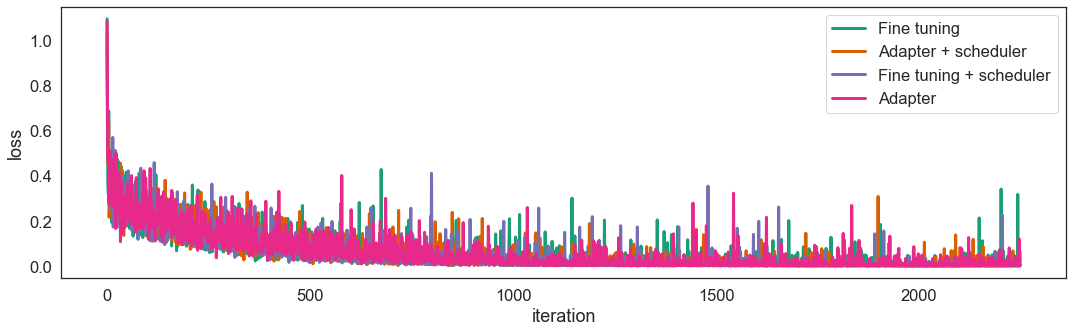

In [44]:
lossABTE = np.loadtxt('model_ABTE/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')
lossABTE_AS = np.loadtxt('model_ABTE_adapter_scheduler/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')
lossABTE_S = np.loadtxt('model_ABTE_scheduler/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')
lossABTE_A = np.loadtxt('model_ABTE_adapter/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')

sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5, palette="Dark2")
fig, ax = plt.subplots(figsize=(18,5))

sns.lineplot(range(len(lossABTE)), lossABTE, ax=ax, label = 'Fine tuning')
sns.lineplot(range(len(lossABTE_AS)), lossABTE_AS, ax=ax, label = 'Adapter + scheduler')
sns.lineplot(range(len(lossABTE_S)), lossABTE_S, ax=ax, label = 'Fine tuning + scheduler')
sns.lineplot(range(len(lossABTE_A)), lossABTE_A, ax=ax, label = 'Adapter')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')

if not os.path.isdir('results_ABTE'):
    os.makedirs('results_ABTE')
fig.savefig('results_ABTE/loss_lr{:.5f}_epochs{}_batch{}.pdf'.format(lr, epochs, batch), dpi=300, bbox_inches='tight')
# ax.set_yscale('log')
# fig.savefig('results_ABTE/log_loss_lr{:.5f}_epochs{}_batch{}.pdf'.format(lr, epochs, batch), dpi=300, bbox_inches='tight')


In [86]:
# adapter training 
dftest = pd.read_csv('model_ABTE_adapter/results/test_pred_lr3.0000000000000004e-05_epochs5_batch8.csv')
test_pred = dftest['Predicted']

test_tags_real = [t.strip('][').split(', ') for t in data_test['Tags']]
test_tags_real = [[int(i) for i in t] for t in test_tags_real]

test_pred = [t.strip('][').split(', ') for t in test_pred]
test_pred = [[int(i) for i in t] for t in test_pred]


ABTE_data = tag_to_word_df(data_test, 'gold terms', test_tags_real)
ABTE_data = tag_to_word_df(ABTE_data, 'pred terms', test_pred)
ABTE_data

,Tokens,Tags,Polarities,Predicted,Actual,gold terms,pred terms,predicted_tags
0,"['The', 'bread', 'is', 'top', 'notch', 'as', '...","[0, 1, 0, 0, 0, 0, 0, 0]","[-1, 2, -1, -1, -1, -1, -1, -1]","[0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0]",[bread],[bread],"[0, 1, 0, 0, 0, 0, 0, 0]"
1,"['I', 'have', 'to', 'say', 'they', 'have', 'on...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0]",[delivery],"[delivery, times]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"
2,"['Food', 'is', 'always', 'fresh', 'and', 'hot'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[Food],[Food],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"['Did', 'I', 'mention', 'that', 'the', 'coffee...","[0, 0, 0, 0, 0, 1, 0, 0, 0]","[-1, -1, -1, -1, -1, 2, -1, -1, -1]","[0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0]",[coffee],[coffee],"[0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,"['Certainly', 'not', 'the', 'best', 'sushi', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[place],[very],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
1114,"['Although', 'the', 'restaurant', 'itself', 'i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",[food],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1115,"['Creamy', 'appetizers', '--', 'taramasalata',...","[1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...","[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, ...","[1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Creamy, taramasalata, eggplant, warm]","[appetizers, --, taramasalata, salad, ,, and, ...","[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, ..."
1116,"['Creamy', 'appetizers', '--', 'taramasalata',...","[1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, ...","[1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Creamy, taramasalata, eggplant, warm]","[appetizers, --, taramasalata, salad, ,, and, ...","[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, ..."
1117,"['Creamy', 'appetizers', '--', 'taramasalata',...","[1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1...","[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, ...","[1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Creamy, taramasalata, eggplant, warm]","[appetizers, --, taramasalata, salad, ,, and, ...","[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, ..."


## Draw clouds

In [104]:
def word_cloud (data):
    from wordcloud import WordCloud
    wordcloud = WordCloud( collocations=False,
                          background_color="cornflowerblue",
                          colormap="magma",
                          max_words=50).generate(data)

    return wordcloud

def target_predicted_wordcloud(targets, predicted, file_name):
    
    sns.set_theme(style='white', font_scale=2)
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))
    ax[0].imshow(word_cloud(targets))
    ax[0].axis("off")
    ax[0].set_title("Target")
    ax[1].imshow(word_cloud(predicted))
    ax[1].axis("off")
    ax[1].set_title("Predicted")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')

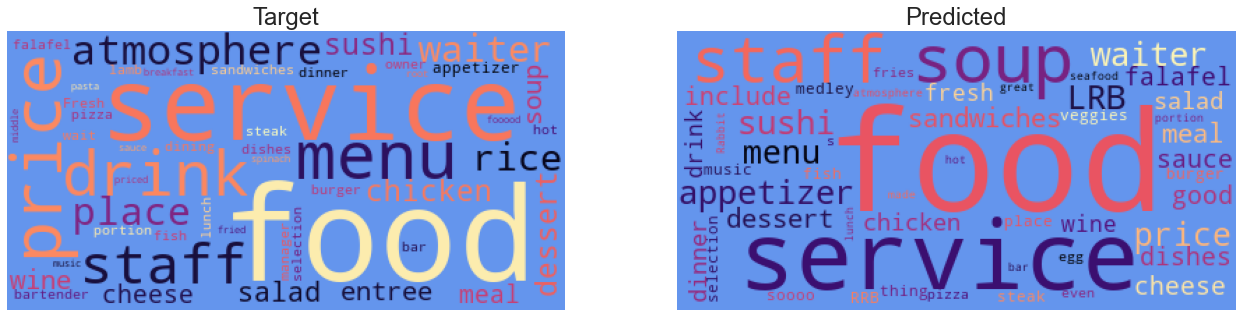

In [105]:
# from utils import target_predicted_wordcloud
import itertools

gold_terms = ABTE_data['gold terms'].values.flatten().tolist()
gold_terms = list(itertools.chain(*gold_terms))

pred_terms = ABTE_data['pred terms'].values.flatten().tolist()
pred_terms = list(itertools.chain(*pred_terms))
target_predicted_wordcloud(' '.join(gold_terms), ' '.join(pred_terms), "results_ABTE/adapter_extracted_terms_wordcloud.pdf")

# ABSA

In [39]:
from transformers import BertModel
from transformers import get_scheduler

import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

import time
import numpy as np
import os
from tqdm import tqdm

class ABSADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        tokens, tags, pols = self.df.iloc[idx, :3].values

        tokens = tokens.replace("'", "").strip("][").split(', ')
        tags = tags.strip('][').split(', ')
        pols = pols.strip('][').split(', ')

        bert_tokens = []
        bert_att = []
        pols_label = 0
        for i in range(len(tokens)):
            t = self.tokenizer.tokenize(tokens[i])
            bert_tokens += t
            if int(pols[i]) != -1:
                bert_att += t
                pols_label = int(pols[i])

        segment_tensor = [0] + [0]*len(bert_tokens) + [0] + [1]*len(bert_att)
        bert_tokens = ['[cls]'] + bert_tokens + ['[sep]'] + bert_att
        

        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)

        ids_tensor = torch.tensor(bert_ids)
        pols_tensor = torch.tensor(pols_label)
        segment_tensor = torch.tensor(segment_tensor)

        return bert_tokens, ids_tensor, segment_tensor, pols_tensor

    def __len__(self):
        return len(self.df)

class ABSABert(torch.nn.Module):
    def __init__(self, pretrain_model, adapter=True):
        super(ABSABert, self).__init__()
        self.adapter = adapter
        if adapter:
            from transformers.adapters import BertAdapterModel
            self.bert = BertAdapterModel.from_pretrained(pretrain_model)
        else: self.bert = BertModel.from_pretrained(pretrain_model)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, ids_tensors, lable_tensors, masks_tensors, segments_tensors):
        out_dict = self.bert(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors)
        linear_outputs = self.linear(out_dict['pooler_output'])

        if lable_tensors is not None:
            loss = self.loss_fn(linear_outputs, lable_tensors)
            return loss
        else:
            return linear_outputs


class ABSAModel ():
    def __init__(self, tokenizer, adapter=True):
        self.model = ABSABert('bert-base-uncased')
        self.tokenizer = tokenizer
        self.trained = False
        self.adapter = adapter

    def padding(self, samples):
        from torch.nn.utils.rnn import pad_sequence
        ids_tensors = [s[1] for s in samples]
        ids_tensors = pad_sequence(ids_tensors, batch_first=True)

        segments_tensors = [s[2] for s in samples]
        segments_tensors = pad_sequence(segments_tensors, batch_first=True)

        label_ids = torch.stack([s[3] for s in samples])
        
        masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
        masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    
        return ids_tensors, segments_tensors, masks_tensors, label_ids

    def load_model(self, model, path):
        model.load_state_dict(torch.load(path), strict=False)
        
    def save_model(self, model, name):
        torch.save(model.state_dict(), name)        
                
    def train(self, data, epochs, device, batch_size=32, lr=1e-5, load_model=None, lr_schedule=True):
        
        #load model if lead_model is not None
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
                self.trained = True
            else:
                print("lead_model not found")

        ds = ABSADataset(data, self.tokenizer)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=self.padding)
        
        self.model = self.model.to(device)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        num_training_steps = epochs * len(loader)
        if lr_schedule: lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

        self.losses = []

        all_data = len(loader)-1

        for epoch in range(epochs):
            finish_data = 0
            current_times = []
            n_batches = int(len(data)/batch_size)

            if self.adapter:
                if lr_schedule: dir_name  = "model_ABSA_adapter_scheduler"
                else: dir_name = "model_ABSA_adapter"
            else:
                if lr_schedule: dir_name  = "model_ABSA_scheduler"
                else: dir_name = "model_ABSA"

            if not os.path.exists(dir_name):
                os.mkdir(dir_name)  

            for nb in range((n_batches)):
                t0 = time.time()

                ids_tensors, segments_tensors, masks_tensors, label_ids = next(iter(loader))
                ids_tensors = ids_tensors.to(device)
                segments_tensors = segments_tensors.to(device)
                label_ids = label_ids.to(device)
                masks_tensors = masks_tensors.to(device)

                loss = self.model(ids_tensors=ids_tensors, lable_tensors=label_ids, 
                                    masks_tensors=masks_tensors, segments_tensors=segments_tensors)
                self.losses.append(loss.item())
                loss.backward()
                optimizer.step()
                if lr_schedule: lr_scheduler.step()
                optimizer.zero_grad()

                finish_data += 1
                current_time = round(time.time() - t0,3)
                current_times.append(current_time)

                print("epoch: {}\tbatch: {}/{}\tloss: {}\tbatch time: {}\ttotal time: {}"\
                    .format(epoch, finish_data, all_data, loss.item(), current_time, sum(current_times)))
            
                np.savetxt('{}/losses_lr{}_epochs{}_batch{}.txt'.format(dir_name, lr, epochs, batch_size), self.losses)

            self.save_model(self.model, '{}/model_lr{}_epochs{}_batch{}.pkl'.format(dir_name, lr, epoch, batch_size))
            self.trained = True

    def history (self):
        if self.trained:
            return self.losses
        else:
            raise Exception('Model not trained')

    def predict(self, sentence, aspect, load_model=None, device='cpu'):
         # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        t1 = self.tokenizer.tokenize(sentence)
        t2 = self.tokenizer.tokenize(aspect)

        word_pieces = ['[cls]']
        word_pieces += t1
        word_pieces += ['[sep]']
        word_pieces += t2

        segment_tensor = [0] + [0]*len(t1) + [0] + [1]*len(t2)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        input_tensor = torch.tensor([ids]).to(device)
        segment_tensor = torch.tensor(segment_tensor).to(device)

        with torch.no_grad():
            outputs = self.model(input_tensor, None, None, segments_tensors=segment_tensor)
            _, predictions = torch.max(outputs, dim=1)
        
        return word_pieces, predictions, outputs

    def _accuracy (self, x,y):
        acc = 0
        for i in range(len(x)):
            if x[i] == y[i]:
                acc += 1
        return acc/len(x)

    def predict_batch(self, data, load_model=None, device='cpu'):
        
        tags_real = [t.strip('][').split(', ') for t in data['Tags']]
        tags_real = [[int(i) for i in t] for t in tags_real]

        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')
        
        predictions = []

        for i in tqdm(range(len(data))):
            sentence = data['Tokens'][i]
            sentenceList = sentence.replace("'", "").strip("][").split(', ')
            sentence = ' '.join(sentenceList)
            
            for j in range(len(tags_real[i])):
                if tags_real[i][j] == 1:
                    aspect = sentenceList[j]
                    w, p, _ = self.predict(sentence, aspect, load_model=load_model, device=device)
                    p = int(p)-1
                    predictions.append(p)
                    tags_real[i] = tags_real[i][:len(p)]
        acc = self._accuracy( np.concatenate(tags_real), np.concatenate(predictions))
        return acc, predictions, tags_real

    def _accuracy (self, x,y):
        return np.mean(np.array(x) == np.array(y))

    def test(self, dataset, load_model=None, device='cpu'):
        from sklearn.metrics import classification_report
        # load model if exists
        if load_model is not None:
            if os.path.exists(load_model):
                self.load_model(self.model, load_model)
            else:
                raise Exception('Model not found')
        else:
            if not self.trained:
                raise Exception('model not trained')

        # dataset and loader
        ds = ABSADataset(dataset, self.tokenizer)
        loader = DataLoader(ds, batch_size=50, shuffle=True, collate_fn=self.padding)

        pred = []#padded list
        trueth = [] #padded list
     
        with torch.no_grad():
            for data in tqdm(loader):
            
                ids_tensors, segments_tensors, masks_tensors, label_ids = data
                ids_tensors = ids_tensors.to(device)
                segments_tensors = segments_tensors.to(device)
                masks_tensors = masks_tensors.to(device)

                outputs = self.model(ids_tensors, None, masks_tensors=masks_tensors, 
                                    segments_tensors=segments_tensors)
                
                _, p = torch.max(outputs, dim=1)   
                
                pred += list([int(i) for i in p])
                trueth += list([int(i) for i in label_ids])    
        acc = self._accuracy(pred, trueth)
        class_report = classification_report(trueth, pred, target_names=['none', 'start of AT', 'mark of AT'])
        return acc, class_report
        
    def accuracy(self, data, load_model=None, device='cpu'):
        a, p = self.test(data, load_model=load_model, device=device)
        return a

In [40]:
# from absa import ABSAModel
modelABSA = ABSAModel(tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertAdapterModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertAdapterModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertAdapterModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
modelABSA.train(data, batch_size=8, lr=1e-5, epochs=5, device=DEVICE)

KeyboardInterrupt: 

In [41]:
model_path = 'model_ABSA_adapter_scheduler/model_lr3.0000000000000004e-05_epochs4_batch8.pkl'
SAtest_accuracy, SAtest_pred, SAtest_targets = modelABSA.test(data_test[:100], load_model=model_path, device=DEVICE)

0/100
bread
0
delivery
0
times
0
2/100
Food
0
coffee
0
4/100
place
0
people
0
6/100
Japanese
0
food
0
asian
0
salad
0
8/100
spicy


KeyboardInterrupt: 

In [42]:
x, y, z = modelABSA.predict("the food is disgusting", "food", load_model=model_path)
print(x), print(y), print(z)

['[cls]', 'the', 'food', 'is', 'disgusting', '[sep]', 'food']
tensor([0])
tensor([[ 7.2932, -2.9982, -3.0620]])


(None, None, None)

In [ ]:
model_path = 'model_ABSA/model_lr0.0001_epochs9_batch64.pkl'
SAtrain_accuracy, SAtrain_pred, SAtrain_targets = modelABSA.test(data, load_model=model_path, device=DEVICE)

In [ ]:
#save results
if not os.path.exists('model_ABSA/results'):
    os.makedirs('model_ABSA/results')
data_test['Predicted'] = SAtest_pred
data_test['Actual'] = SAtest_targets
data_test.to_csv('model_ABSA/results/test_pred.csv', index=False)
data['Predicted'] = SAtrain_pred
data['Actual'] = SAtrain_targets
data.to_csv('model_ABSA/results/train_pred.csv', index=False)
test_accuracy = np.array(SAtest_accuracy)
train_accuracy = np.array(SAtrain_accuracy)
np.save('model_ABSA/results/test_accuracy.npy', SAtest_accuracy)
np.save('model_ABSA/results/train_accuracy.npy', SAtrain_accuracy)